# Setup

In [ ]:
# retrieve data
!wget 'https://s3.amazonaws.com/data-platform-tutorial/tweets.csv.gz'

In [ ]:
# uncompress data
!tar -xvzf tweets.csv.gz

In [1]:
## standard python imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## pyspark imports
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as f

# create a spark session
spark = (SparkSession.builder
         .master("local")
         .appName("exploratory notebook")
         .enableHiveSupport()
         .getOrCreate())

# Loading Data

In [2]:
# read csv as a dataframe
df = (spark.read
      .options(header=True, inferSchema=True)
      .csv('tweets.csv'))

# Basic Exploration / Wrangling

### How many records do we have?

In [3]:
## find the count of rows
num_records = df.count()
# print this number
print("{:,} records in the file".format(num_records))

241,489 records in the file


### What are the columns and associated data types?

In [4]:
## print the data types
print(df.dtypes)

[('id', 'bigint'), ('when', 'bigint'), ('sender', 'string'), ('term', 'string'), ('value', 'string')]


### What does the data look like?

In [5]:
## look at the first few rows
df.show(5, truncate=20)

+------------------+-------------+---------------+----+--------------------+
|                id|         when|         sender|term|               value|
+------------------+-------------+---------------+----+--------------------+
|866772705256783872|1495489691000|    AlyssaWager| nfl|#NFL #Cards: NEW ...|
|866772707030966272|1495489691000|BostonCeltics1v| nba|#NBA #Celtics #Ar...|
|866772707769163777|1495489692000|    playerpress| nfl|#NFL Wire: Aaron ...|
|866772707072811009|1495489691000|    IslaSambell| nfl|#Cards HOUSTON #T...|
|866772708511678466|1495489692000|      delimavim| nba|"RT @Fenerizmnet:...|
+------------------+-------------+---------------+----+--------------------+
only showing top 5 rows



### The `when` column is a unix timestamp with millisecond precision. How can we represent it as a timestamp?

In [6]:
# create a new column, cast as a timestamp
df = df.withColumn('ts', (df['when']/1000).cast('timestamp'))

# look at the data
df.show(5, truncate=25)

+------------------+-------------+---------------+----+-------------------------+---------------------+
|                id|         when|         sender|term|                    value|                   ts|
+------------------+-------------+---------------+----+-------------------------+---------------------+
|866772705256783872|1495489691000|    AlyssaWager| nfl|#NFL #Cards: NEW YORK ...|2017-05-22 21:48:11.0|
|866772707030966272|1495489691000|BostonCeltics1v| nba|#NBA #Celtics #Arena A...|2017-05-22 21:48:11.0|
|866772707769163777|1495489692000|    playerpress| nfl|#NFL Wire: Aaron Donal...|2017-05-22 21:48:12.0|
|866772707072811009|1495489691000|    IslaSambell| nfl|#Cards HOUSTON #Texans...|2017-05-22 21:48:11.0|
|866772708511678466|1495489692000|      delimavim| nba|"RT @Fenerizmnet: Rıdv...|2017-05-22 21:48:12.0|
+------------------+-------------+---------------+----+-------------------------+---------------------+
only showing top 5 rows



## Counts, Basic Visualization

### How many tweets were recorded for each term?

In [7]:
# group by 'term' and count rows, show the result
df.groupby('term').count().show()

+----+------+
|term| count|
+----+------+
| nfl| 34483|
| nba|207006|
+----+------+



### How can we visualize the above?

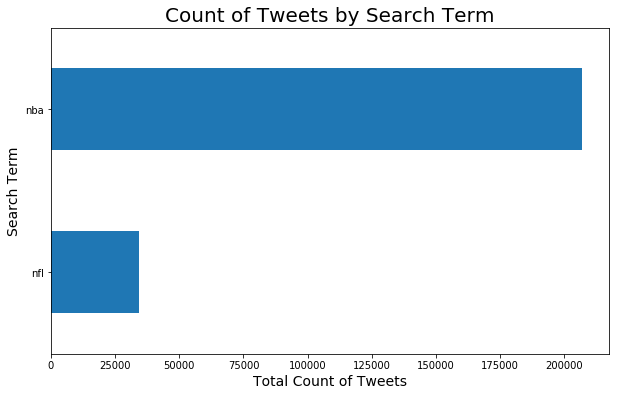

In [18]:
# first output to pandas
pandas_df = df.groupby('term').count().toPandas()

# set up figure, axes
fig, ax = plt.subplots(figsize=(10,6));

# use built-in plotting function from pandas
pandas_df.plot(x='term', y='count', kind='barh', legend=False, ax=ax);

# add axis labels
ax.set_xlabel("Total Count of Tweets", size=14);
ax.set_ylabel("Search Term", size=14);
ax.set_title("Count of Tweets by Search Term", size=20);

## Tweet Volume Over Time

### What does the volume of tweets look like over time?

In [9]:
# group by 1 minute window, count
counts_by_minute = (df.groupby(f.window('ts', '1 minute'))
                    .count())
# show the dataframe
counts_by_minute.show(10, truncate=100)

+---------------------------------------------+-----+
|                                       window|count|
+---------------------------------------------+-----+
|[2017-05-23 00:33:00.0,2017-05-23 00:34:00.0]|  275|
|[2017-05-23 03:24:00.0,2017-05-23 03:25:00.0]|  495|
|[2017-05-23 05:13:00.0,2017-05-23 05:14:00.0]|  272|
|[2017-05-22 22:25:00.0,2017-05-22 22:26:00.0]|  177|
|[2017-05-22 23:35:00.0,2017-05-22 23:36:00.0]|  204|
|[2017-05-23 00:02:00.0,2017-05-23 00:03:00.0]|  208|
|[2017-05-23 01:52:00.0,2017-05-23 01:53:00.0]|  327|
|[2017-05-23 02:58:00.0,2017-05-23 02:59:00.0]|  392|
|[2017-05-23 03:56:00.0,2017-05-23 03:57:00.0]| 1066|
|[2017-05-23 06:00:00.0,2017-05-23 06:01:00.0]|  207|
+---------------------------------------------+-----+
only showing top 10 rows



### Visualize the above data

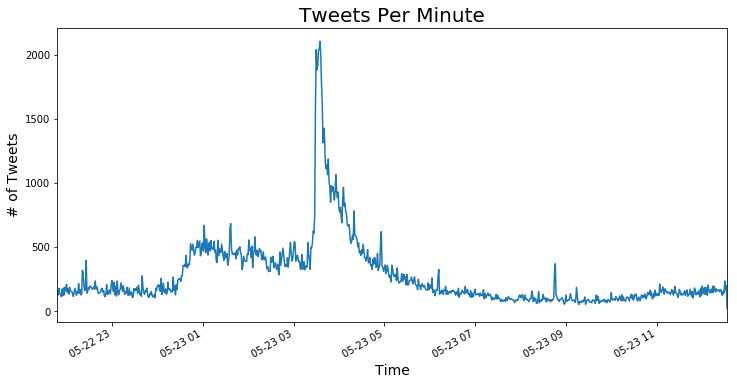

In [20]:
# first output to pandas
pandas_df = counts_by_minute.toPandas()
# use pandas to extract the first timestamp in the 'window' column
# and assign it to the 'time' column
pandas_df['time'] = pandas_df['window'].apply(lambda w: w[0])

# set up figure, axes
fig, ax = plt.subplots(figsize=(12,6))

# use built-in plotting function from pandas
pandas_df.plot(x='time', y='count', legend=None, ax=ax);

# add axis labels
ax.set_xlabel("Time", size=14);
ax.set_ylabel("# of Tweets", size=14);
ax.set_title("Tweets Per Minute", size=20);

## Tweet Volume Over Time, By Search Term

### What does the time series of each term look like?

In [11]:
# group by term, and 1-minute window
counts_by_minute_by_term = (df.groupby('term', 
                                       f.window('ts', '1 minute'))
                            .count())
# show the dataframe
counts_by_minute_by_term.show(10, truncate=100)

+----+---------------------------------------------+-----+
|term|                                       window|count|
+----+---------------------------------------------+-----+
| nba|[2017-05-23 01:25:00.0,2017-05-23 01:26:00.0]|  415|
| nba|[2017-05-23 06:28:00.0,2017-05-23 06:29:00.0]|  135|
| nba|[2017-05-23 06:52:00.0,2017-05-23 06:53:00.0]|  116|
| nfl|[2017-05-23 07:10:00.0,2017-05-23 07:11:00.0]|   14|
| nba|[2017-05-23 10:40:00.0,2017-05-23 10:41:00.0]|  106|
| nfl|[2017-05-23 11:53:00.0,2017-05-23 11:54:00.0]|   24|
| nfl|[2017-05-22 23:26:00.0,2017-05-22 23:27:00.0]|   69|
| nba|[2017-05-23 02:07:00.0,2017-05-23 02:08:00.0]|  376|
| nba|[2017-05-23 03:38:00.0,2017-05-23 03:39:00.0]| 1561|
| nba|[2017-05-23 03:54:00.0,2017-05-23 03:55:00.0]|  830|
+----+---------------------------------------------+-----+
only showing top 10 rows



### Visualize the above data

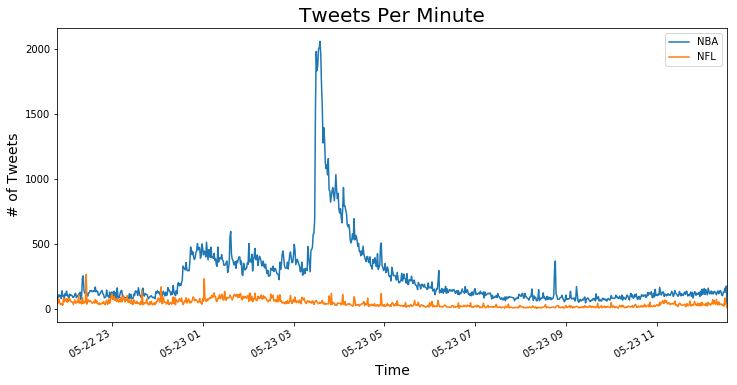

In [12]:
# first output to pandas
pandas_df = counts_by_minute_by_term.toPandas()
# use pandas to extract the first timestamp in the 'window' column
# and assign it to the 'time' column
pandas_df['time'] = pandas_df['window'].apply(lambda w: w[0])

# set up figure, axes
fig, ax = plt.subplots(figsize=(12,6))

# plot each term individually
for term, group in pandas_df.groupby('term'):
    group.plot(x='time', y='count', label=term.upper(), ax=ax);

# set up axes labels
ax.set_xlabel("Time", size=14);
ax.set_ylabel("# of Tweets", size=14);
ax.set_title("Tweets Per Minute", size=20);

## Inspecting A Subset Of NBA Tweets

### What are people tweeting about at a particular time?

In [13]:
# set the bounds of the time window we'd like to look at
start_time = '2017-05-23 03:45:00'
end_time = '2017-05-23 04:15:00'

# first select only nba tweets
nba_tweets = df[(df['term'] == 'nba') & (df['ts'].between(start_time, end_time))]

# show the text of the first few tweets at that time
nba_tweets.select('value').show(10, truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                               value|
+----------------------------------------------------------------------------------------------------+
|RT @FOXSports: WELP 😳The @warriors sweep the Spurs and head to the NBA Finals for the third stra...|
| RT @SportsCenter: No one in NBA history has ever started the playoffs 12-0. https://t.co/CvdNX6uibm|
|RT @SportsCenter: Not one ... not two ... but THREE straight NBA Finals appearances. https://t.co...|
|RT @warriors: The Warriors are the first team in NBA history to start a postseason 12-0. #Strengt...|
|RT @NBA: Boston Celtics guard Marcus Smart defies odds with miraculous Game 3 performance (via @j...|
|                    A reader's 2017 NBA Mock Draft with player comparisons - https://t.co/QUEw0cky4h|
|RT @NBA: For the third consecutive season, the @Warriors​ are #NBAFinals 

## What words are people using in these tweets?

### 1. Split tweets into arrays of words

In [14]:
# use pyspark's built-in text processing tools
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# split each tweet into it's constituent words
tokenizer = Tokenizer(inputCol='value', outputCol='words')
words_df = tokenizer.transform(nba_tweets)

# show the result
words_df.select('words').show(10, truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                               words|
+----------------------------------------------------------------------------------------------------+
|[rt, @foxsports:, welp, 😳the, @warriors, sweep, the, spurs, and, head, to, the, nba, finals, for...|
|[rt, @sportscenter:, no, one, in, nba, history, has, ever, started, the, playoffs, 12-0., https:/...|
|[rt, @sportscenter:, not, one, ..., not, two, ..., but, three, straight, nba, finals, appearances...|
|[rt, @warriors:, the, warriors, are, the, first, team, in, nba, history, to, start, a, postseason...|
|[rt, @nba:, boston, celtics, guard, marcus, smart, defies, odds, with, miraculous, game, 3, perfo...|
|        [a, reader's, 2017, nba, mock, draft, with, player, comparisons, -, https://t.co/quew0cky4h]|
|[rt, @nba:, for, the, third, consecutive, season,, the, @warriors​, are, 

### 2. Count the words

In [15]:
# count the resulting words
exploded = words_df.select(f.explode('words').alias('word'))
word_counts = exploded.groupby('word').count()

# show the result, in descending order
word_counts.orderBy('count', ascending=False).show(10)

+--------+-----+
|    word|count|
+--------+-----+
|      rt|19744|
|     the|16749|
|     nba|14231|
|      to| 7930|
|      in| 6875|
|       a| 6798|
|   @nba:| 5316|
|warriors| 3774|
|      as| 3624|
| history| 3476|
+--------+-----+
only showing top 10 rows



### 3. Get rid of common, non-informative words

In [16]:
# use the StopWordsRemover tool to filter word arrays
sw_remover = StopWordsRemover(inputCol='words', outputCol='filtered words')
filtered_words_df = sw_remover.transform(words_df).select('filtered words')

# count the result
exploded = filtered_words_df.select(f.explode('filtered words').alias('word'))
filtered_word_counts = exploded.groupby('word').count()

# show the result, in descending order
filtered_word_counts.orderBy('count', ascending=False).show(10)

+----------+-----+
|      word|count|
+----------+-----+
|        rt|19744|
|       nba|14231|
|     @nba:| 5316|
|  warriors| 3774|
|   history| 3476|
|    finals| 3336|
|     12-0.| 2811|
|      manu| 2693|
|#dubnation| 2582|
|      team| 2553|
+----------+-----+
only showing top 10 rows

